In [1]:
# Libraries
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random


# Dataset Directory
data_dir = "/kaggle/input/new-bangladeshi-crop-disease/BangladeshiCrops/BangladeshiCrops/Crop___Disease"
images_per_disease = 2  
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)


In [2]:
crops = ['Corn', 'Potato', 'Rice', 'Wheat']
def is_image_file(fname):
    return fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif'))

def list_dirs(path):
    return [d for d in sorted(os.listdir(path)) if os.path.isdir(os.path.join(path, d))]

In [3]:
if 'crops' in locals():
    # user-specified order
    crops = [c for c in crops if os.path.isdir(os.path.join(data_dir, c))]
else:
    crops = list_dirs(data_dir)
print("Crops found:", crops)

Crops found: ['Corn', 'Potato', 'Rice', 'Wheat']


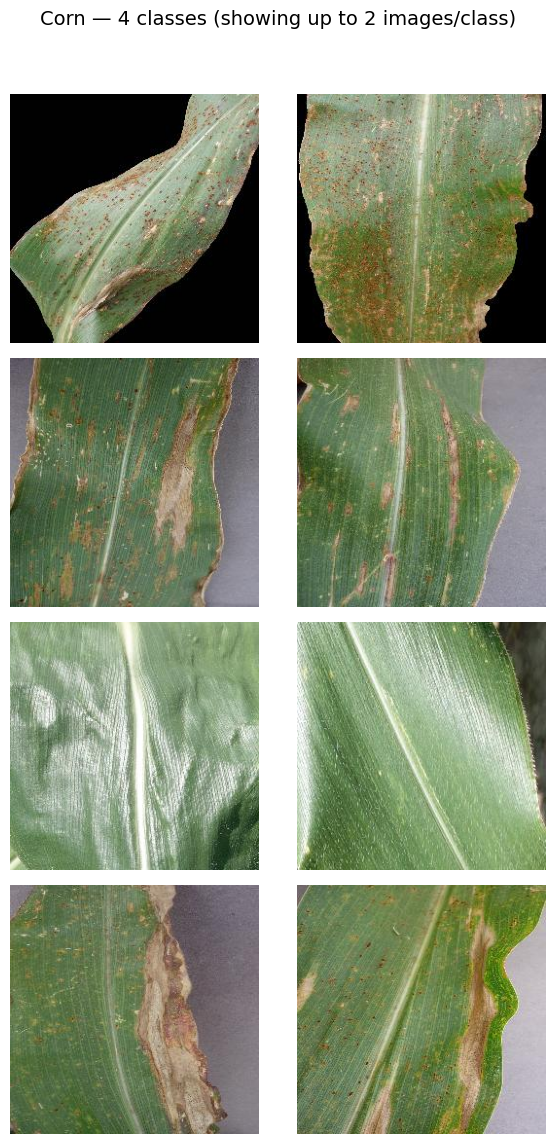

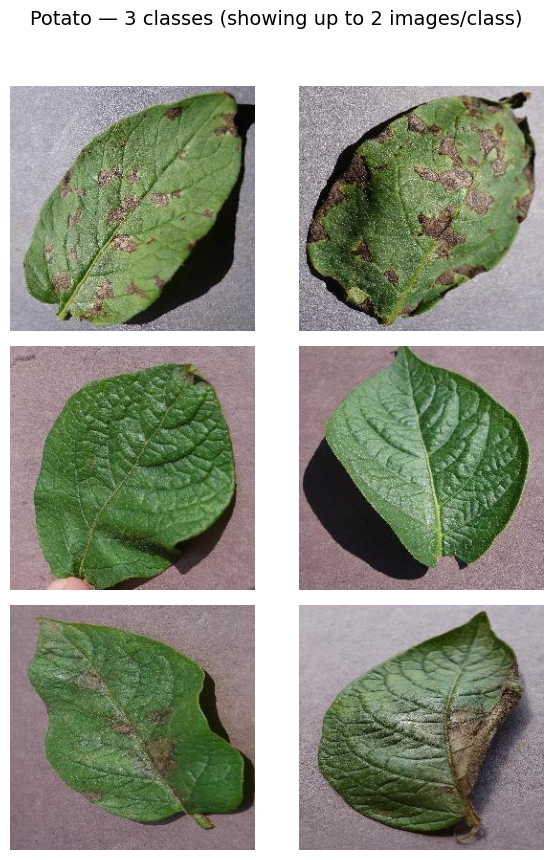

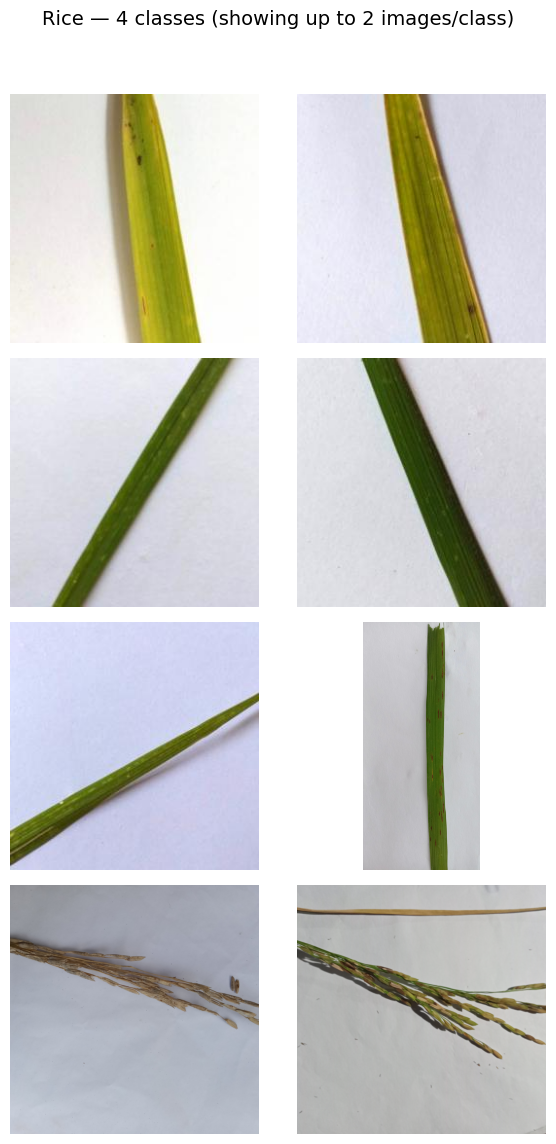

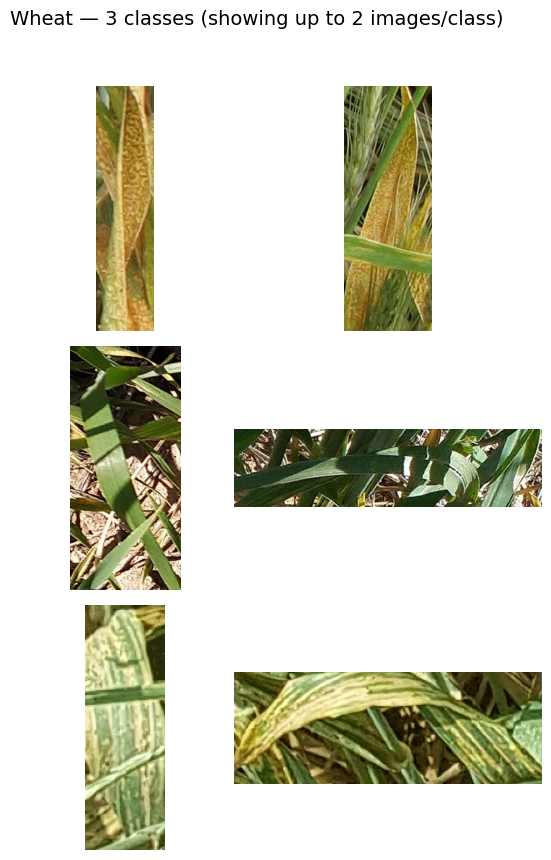

In [4]:
for crop in crops:
    crop_path = os.path.join(data_dir, crop)
    diseases = list_dirs(crop_path)
    if len(diseases) == 0:
        print(f"Warning: no disease subfolders found under {crop_path}. Skipping.")
        continue

    # Compute layout
    rows = len(diseases)
    cols = images_per_disease
    fig_w = max(6, 2.5 * cols)
    fig_h = max(3 * rows, 4)

    plt.figure(figsize=(fig_w, fig_h))
    plt.suptitle(f"{crop} — {len(diseases)} classes (showing up to {images_per_disease} images/class)", fontsize=14)

    subplot_idx = 1
    for i, disease in enumerate(diseases):
        disease_path = os.path.join(crop_path, disease)
        all_files = [f for f in sorted(os.listdir(disease_path)) if is_image_file(f)]
        if len(all_files) == 0:
            # empty folder
            for j in range(cols):
                plt.subplot(rows, cols, subplot_idx); plt.axis('off')
                subplot_idx += 1
            continue

        # choose images_per_disease images (random sample if possible)
        chosen = all_files if len(all_files) <= images_per_disease else list(np.random.choice(all_files, images_per_disease, replace=False))
        # ensure stable order
        chosen = sorted(chosen)

        for j in range(cols):
            plt.subplot(rows, cols, subplot_idx)
            if j < len(chosen):
                img_path = os.path.join(disease_path, chosen[j])
                try:
                    im = Image.open(img_path).convert('RGB')
                    plt.imshow(im)
                    plt.axis('off')
                except Exception as e:
                    plt.text(0.5, 0.5, f"Err\n{os.path.basename(img_path)}", ha='center', va='center')
                    plt.axis('off')
            else:
                plt.axis('off')
            # label the left-most column with disease name
            if j == 0:
                plt.ylabel(disease, rotation=0, labelpad=60, va='center')
            subplot_idx += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [5]:
counts = {}
all_diseases = set()

for crop in crops:
    crop_path = os.path.join(data_dir, crop)
    diseases = list_dirs(crop_path)
    counts[crop] = {}
    for disease in diseases:
        disease_path = os.path.join(crop_path, disease)
        imgs = [f for f in os.listdir(disease_path) if is_image_file(f)]
        cnt = len(imgs)
        counts[crop][disease] = cnt
        all_diseases.add(disease)

# Create DataFrame with diseases as rows and crops as columns
all_diseases = sorted(all_diseases)
df = pd.DataFrame(index=all_diseases, columns=crops).fillna(0).astype(int)

for crop in crops:
    for disease, cnt in counts[crop].items():
        df.loc[disease, crop] = cnt

# Add totals
df.loc['Total'] = df.sum(axis=0)
df['Total_per_disease'] = df.sum(axis=1)

print("\nImage counts (diseases x crops):\n")
print(df)


Image counts (diseases x crops):

                             Corn  Potato  Rice  Wheat  Total_per_disease
Corn___Common_Rust           1192       0     0      0               1192
Corn___Gray_Leaf_Spot         513       0     0      0                513
Corn___Healthy               1162       0     0      0               1162
Corn___Northern_Leaf_Blight   985       0     0      0                985
Potato___Early_Blight           0    1000     0      0               1000
Potato___Healthy                0     152     0      0                152
Potato___Late_Blight            0    1000     0      0               1000
Rice___Brown_Spot               0       0   613      0                613
Rice___Healthy                  0       0  1488      0               1488
Rice___Leaf_Blast               0       0   977      0                977
Rice___Neck_Blast               0       0  1000      0               1000
Wheat___Brown_Rust              0       0     0    902                902
Whe

/tmp/ipykernel_36/2619602880.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.DataFrame(index=all_diseases, columns=crops).fillna(0).astype(int)


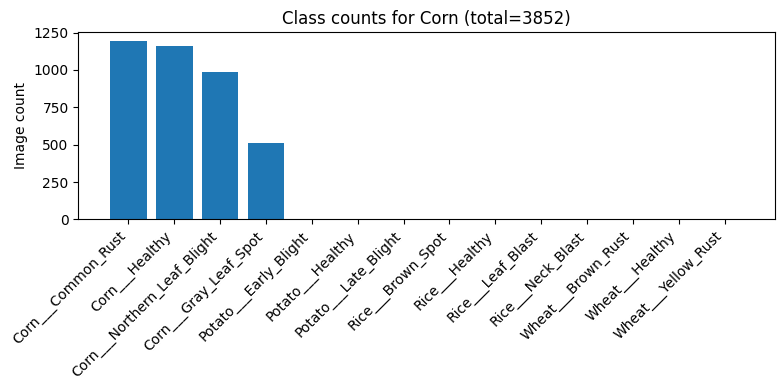

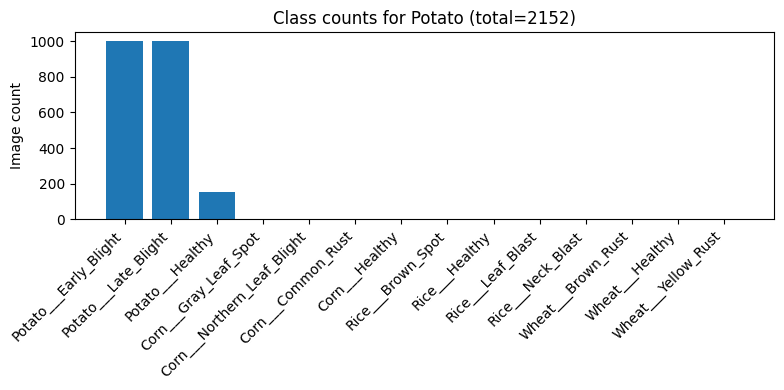

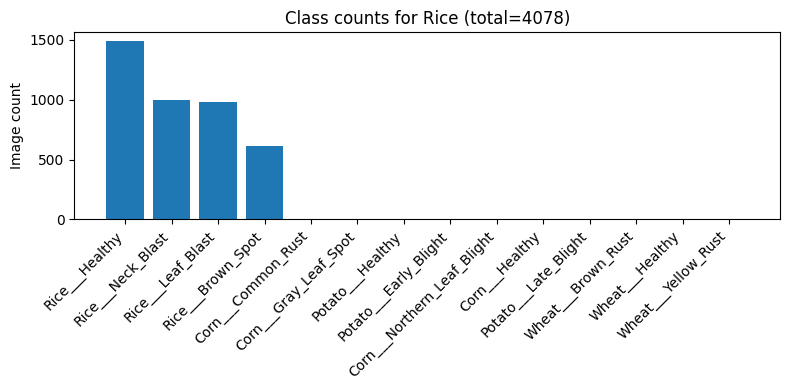

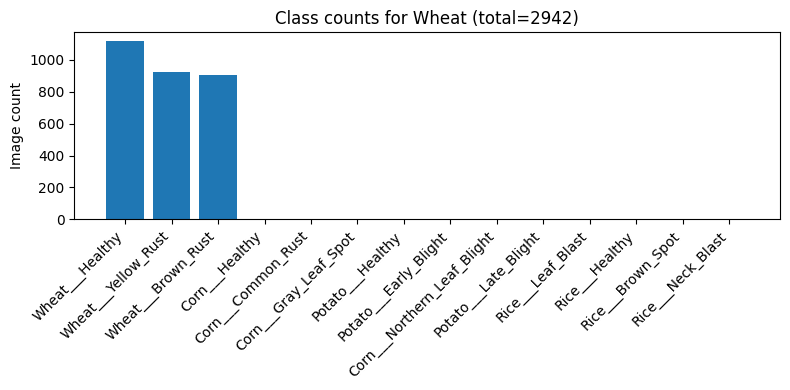

In [6]:
for crop in crops:
    series = df[crop].drop('Total')  # remove totals row if present
    series = series[series.index != 'Total']  # safe guard
    if series.sum() == 0:
        continue
    plt.figure(figsize=(8, 4))
    series_sorted = series.sort_values(ascending=False)
    plt.bar(range(len(series_sorted)), series_sorted.values)
    plt.xticks(range(len(series_sorted)), series_sorted.index, rotation=45, ha='right')
    plt.title(f"Class counts for {crop} (total={int(series.sum())})")
    plt.ylabel("Image count")
    plt.tight_layout()
    plt.show()

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models

# Augmentations for training
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Validation (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
# Dataset for crop classification (top-level folders = crops)
crop_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

# Split train/val (80/20)
train_size = int(0.8 * len(crop_dataset))
val_size = len(crop_dataset) - train_size
train_dataset, val_dataset = random_split(crop_dataset, [train_size, val_size])

# Update val_dataset transforms
val_dataset.dataset.transform = val_transforms

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Crop classes:", crop_dataset.classes)  # ['Corn', 'Potato', 'Rice', 'Wheat']


Crop classes: ['Corn', 'Potato', 'Rice', 'Wheat']


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained model
model = models.resnet18(weights="IMAGENET1K_V1")
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(crop_dataset.classes))  # 4 crops

model = model.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s] 


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

def train_model(model, train_loader, val_loader, epochs=10):
    best_acc = 0.0
    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, running_corrects = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_corrects = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_crop_model.pth")

    print("Training complete. Best Val Acc: {:.4f}".format(best_acc))

train_model(model, train_loader, val_loader, epochs=10)


Epoch 1/10 - Train Loss: 0.0306 Acc: 0.9917 | Val Loss: 0.0024 Acc: 0.9996
Epoch 2/10 - Train Loss: 0.0058 Acc: 0.9981 | Val Loss: 0.0017 Acc: 1.0000
Epoch 3/10 - Train Loss: 0.0017 Acc: 0.9997 | Val Loss: 0.0004 Acc: 0.9996
Epoch 4/10 - Train Loss: 0.0036 Acc: 0.9989 | Val Loss: 0.0056 Acc: 0.9985
Epoch 5/10 - Train Loss: 0.0113 Acc: 0.9963 | Val Loss: 0.0044 Acc: 0.9992
Epoch 6/10 - Train Loss: 0.0052 Acc: 0.9984 | Val Loss: 0.0005 Acc: 1.0000
Epoch 7/10 - Train Loss: 0.0021 Acc: 0.9994 | Val Loss: 0.0025 Acc: 0.9992
Epoch 8/10 - Train Loss: 0.0008 Acc: 0.9997 | Val Loss: 0.0002 Acc: 1.0000
Epoch 9/10 - Train Loss: 0.0003 Acc: 1.0000 | Val Loss: 0.0016 Acc: 0.9992
Epoch 10/10 - Train Loss: 0.0005 Acc: 0.9998 | Val Loss: 0.0018 Acc: 0.9996
Training complete. Best Val Acc: 1.0000


In [17]:
def train_model(model, crop, train_loader, val_loader, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-4)
    best_acc = 0.0

    # Lists to store metrics
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss, running_corrects = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc.item())

        # Validation
        model.eval()
        val_loss, val_corrects = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects.double() / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accs.append(val_acc.item())

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_acc:
            best_acc = val_acc
            model_path = f"{crop}_best_disease_model.pth"
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model for {crop} at {model_path}")

    print("Training complete. Best Val Acc: {:.4f}".format(best_acc))

    # ----- Plot -----
    import matplotlib.pyplot as plt
    epochs_range = range(1, epochs+1)
    plt.figure(figsize=(12,5))
    
    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, label='Train Loss')
    plt.plot(epochs_range, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{crop} Loss')
    plt.legend()
    
    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_accs, label='Train Acc')
    plt.plot(epochs_range, val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'{crop} Accuracy')
    plt.legend()
    
    plt.show()


Corn: ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight']
Crop Disease classes: ['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight']
Epoch 1/10 - Train Loss: 0.1761 Acc: 0.9286 | Val Loss: 0.1085 Acc: 0.9559
Saved best model for Corn at Corn_best_disease_model.pth
Epoch 2/10 - Train Loss: 0.0638 Acc: 0.9796 | Val Loss: 0.1973 Acc: 0.9507
Epoch 3/10 - Train Loss: 0.0531 Acc: 0.9809 | Val Loss: 0.0690 Acc: 0.9689
Saved best model for Corn at Corn_best_disease_model.pth
Epoch 4/10 - Train Loss: 0.0253 Acc: 0.9916 | Val Loss: 0.0762 Acc: 0.9767
Saved best model for Corn at Corn_best_disease_model.pth
Epoch 5/10 - Train Loss: 0.0067 Acc: 0.9987 | Val Loss: 0.0494 Acc: 0.9780
Saved best model for Corn at Corn_best_disease_model.pth
Epoch 6/10 - Train Loss: 0.0056 Acc: 0.9990 | Val Loss: 0.1141 Acc: 0.9663
Epoch 7/10 - Train Loss: 0.0034 Acc: 0.9987 | Val Loss: 0.0559 Acc: 0.9792
Saved best model for Corn

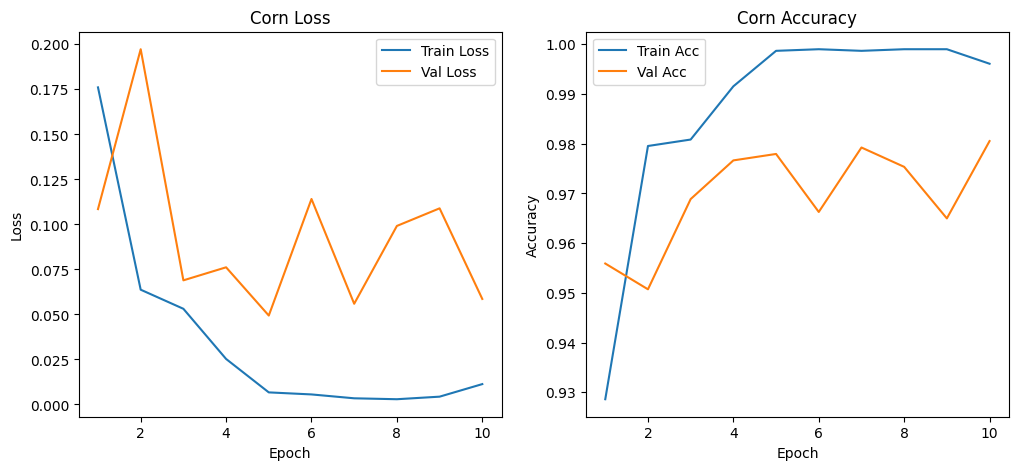

Potato: ['Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight']
Crop Disease classes: ['Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight']
Epoch 1/10 - Train Loss: 0.0985 Acc: 0.9646 | Val Loss: 0.0121 Acc: 0.9930
Saved best model for Potato at Potato_best_disease_model.pth
Epoch 2/10 - Train Loss: 0.0201 Acc: 0.9959 | Val Loss: 0.0049 Acc: 0.9977
Saved best model for Potato at Potato_best_disease_model.pth
Epoch 3/10 - Train Loss: 0.0048 Acc: 0.9988 | Val Loss: 0.0033 Acc: 1.0000
Saved best model for Potato at Potato_best_disease_model.pth
Epoch 4/10 - Train Loss: 0.0022 Acc: 0.9994 | Val Loss: 0.0008 Acc: 1.0000
Epoch 5/10 - Train Loss: 0.0012 Acc: 1.0000 | Val Loss: 0.0005 Acc: 1.0000
Epoch 6/10 - Train Loss: 0.0009 Acc: 1.0000 | Val Loss: 0.0006 Acc: 1.0000
Epoch 7/10 - Train Loss: 0.0010 Acc: 1.0000 | Val Loss: 0.0015 Acc: 1.0000
Epoch 8/10 - Train Loss: 0.0055 Acc: 0.9988 | Val Loss: 0.0040 Acc: 1.0000
Epoch 9/10 - Train Loss: 0.0041 Acc: 0.9983 | V

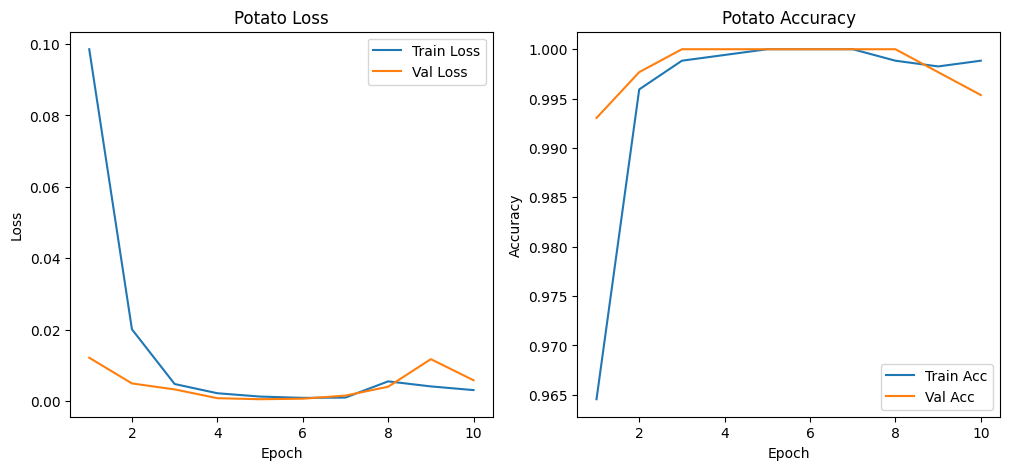

Rice: ['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast']
Crop Disease classes: ['Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Leaf_Blast', 'Rice___Neck_Blast']
Epoch 1/10 - Train Loss: 0.5121 Acc: 0.7943 | Val Loss: 0.3468 Acc: 0.8762
Saved best model for Rice at Rice_best_disease_model.pth
Epoch 2/10 - Train Loss: 0.3035 Acc: 0.8912 | Val Loss: 0.3129 Acc: 0.8873
Saved best model for Rice at Rice_best_disease_model.pth
Epoch 3/10 - Train Loss: 0.2380 Acc: 0.9142 | Val Loss: 0.3068 Acc: 0.8873
Epoch 4/10 - Train Loss: 0.1667 Acc: 0.9427 | Val Loss: 0.2879 Acc: 0.9056
Saved best model for Rice at Rice_best_disease_model.pth
Epoch 5/10 - Train Loss: 0.1493 Acc: 0.9485 | Val Loss: 0.3197 Acc: 0.9020
Epoch 6/10 - Train Loss: 0.1080 Acc: 0.9641 | Val Loss: 0.4328 Acc: 0.8676
Epoch 7/10 - Train Loss: 0.0849 Acc: 0.9712 | Val Loss: 0.3449 Acc: 0.8934
Epoch 8/10 - Train Loss: 0.0907 Acc: 0.9721 | Val Loss: 0.3900 Acc: 0.8995
Epoch 9/10 - Train Loss: 0.0608 Acc: 

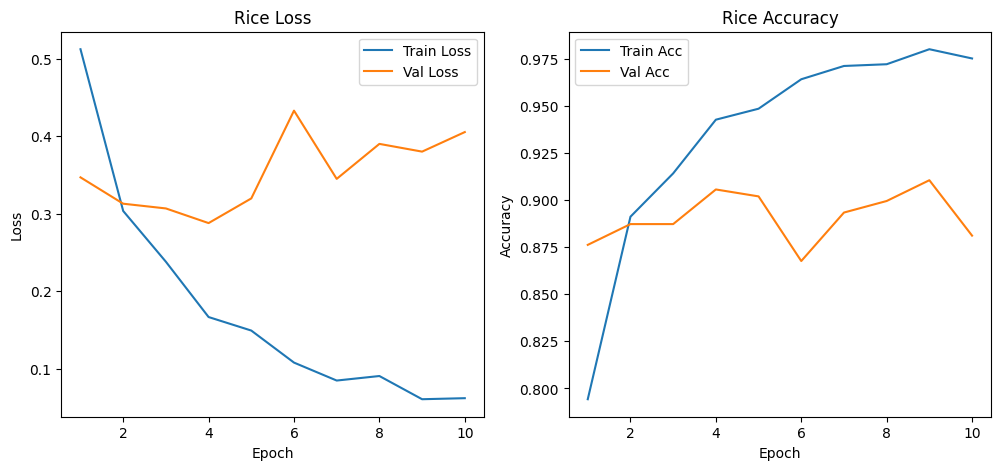

Wheat: ['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']
Crop Disease classes: ['Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']
Epoch 1/10 - Train Loss: 0.0981 Acc: 0.9622 | Val Loss: 0.0353 Acc: 0.9915
Saved best model for Wheat at Wheat_best_disease_model.pth
Epoch 2/10 - Train Loss: 0.0266 Acc: 0.9902 | Val Loss: 0.0106 Acc: 0.9966
Saved best model for Wheat at Wheat_best_disease_model.pth
Epoch 3/10 - Train Loss: 0.0127 Acc: 0.9966 | Val Loss: 0.0088 Acc: 0.9983
Saved best model for Wheat at Wheat_best_disease_model.pth
Epoch 4/10 - Train Loss: 0.0026 Acc: 1.0000 | Val Loss: 0.0036 Acc: 0.9983
Epoch 5/10 - Train Loss: 0.0188 Acc: 0.9932 | Val Loss: 0.0095 Acc: 0.9983
Epoch 6/10 - Train Loss: 0.0079 Acc: 0.9975 | Val Loss: 0.0164 Acc: 0.9966
Epoch 7/10 - Train Loss: 0.0111 Acc: 0.9966 | Val Loss: 0.0610 Acc: 0.9745
Epoch 8/10 - Train Loss: 0.0219 Acc: 0.9932 | Val Loss: 0.0165 Acc: 0.9983
Epoch 9/10 - Train Loss: 0.0075 Acc: 0.9962 | Val Loss: 0.0208 A

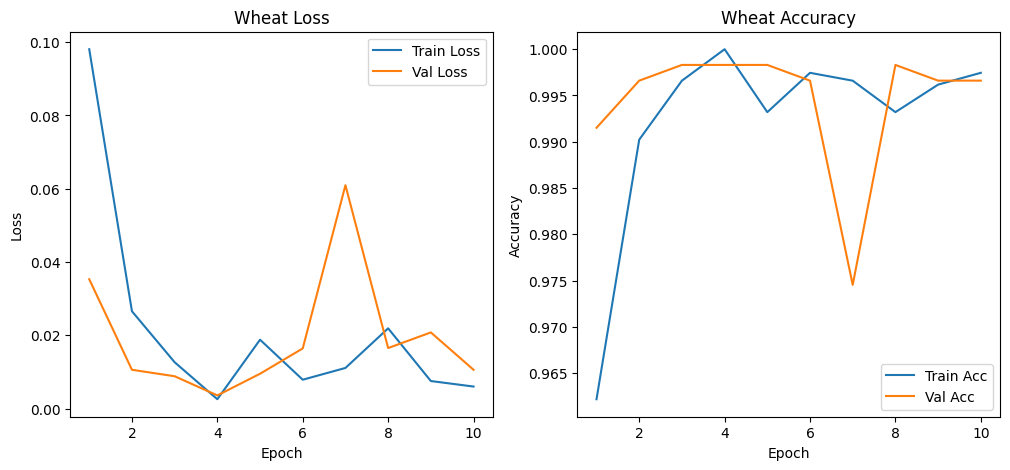

In [18]:
# Dataset for disease classification
for crop in crops:
    crop_path = os.path.join(data_dir, crop)
    disease_dataset = datasets.ImageFolder(root=crop_path, transform=train_transforms)
    print(f"{crop}: {disease_dataset.classes}")

    # Split train/val (80/20)
    train_size = int(0.8 * len(disease_dataset))
    val_size = len(disease_dataset) - train_size
    train_dataset, val_dataset = random_split(disease_dataset, [train_size, val_size])
    
    # Update val_dataset transforms
    val_dataset.dataset.transform = val_transforms
    
    # Dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
    
    print("Crop Disease classes:", disease_dataset.classes) 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load pre-trained model
    model = models.resnet18(weights="IMAGENET1K_V1")
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(disease_dataset.classes))  
    
    model = model.to(device)
    train_model(model, crop, train_loader, val_loader, epochs=10)